# Conditional Wasserstein Generative Adversarial Network

Conditional Generative Adversarial Nets - [Paper](https://arxiv.org/pdf/1411.1784.pdf)

Conditional GANs are constructed by feeding the data we wish to condition on to both the generator and discriminator.

$\min\limits_G\max\limits_D V(D,G) = \mathbb{E}_{x\sim p_{data}(x)} [log D(x|y)] + \mathbb{E}_{z\sim p_z(z)} [log(1 - D(G(z|y)))]$

### Improvements

* Wasserstein loss for discriminator and generator models
* Linear activation in discriminator output instead of sigmoid
* Clip discriminator weights after each update
* Label smoothing for real outputs
* RMSprop instead of Adam
    
Note: The following implementation is for continuous variables. For discrete variables, implement an embedding layer.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from mpl_toolkits import mplot3d
import tensorflow as tf

In [2]:
from data.synthetic import get_tf_normal_dataset, plot_data, get_normal_data

# X, y, dataset = get_tf_normal_dataset(n=1000, xy_features=(2,1), plot=True)

In [3]:
X, y = get_normal_data(1000, xy_features=(2,1))
dataset = tf.data.Dataset \
    .from_tensor_slices((X,y)) \
    .shuffle(X.size).batch(32)

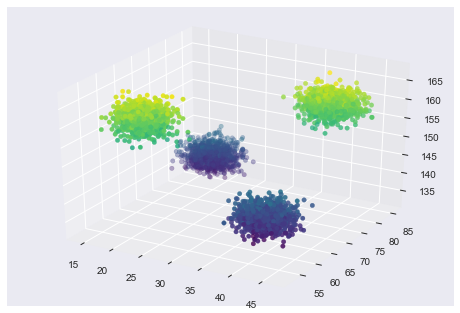

In [4]:
plot_data(X,y)

In [11]:
import datetime
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy

class CGAN:
    """Generate y conditioned on x."""
    def __init__(self, x_features, y_features, latent_dim=32, g_hidden=16, d_hidden=16, label_smooth=0.9, d_dropout=0.4, d_clip=0.01):
        self.x_features = x_features
        self.y_features = y_features
        self.latent_dim = latent_dim
        self.g_hidden = g_hidden
        self.d_hidden = d_hidden
        self.label_smooth = label_smooth
        self.d_dropout = d_dropout
        self.d_clip = d_clip
        self.g_optimizer = RMSprop(1e-4)
        self.d_optimizer = RMSprop(1e-4)
        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()
    
    def build_generator(self):
        """Generator model consists of a dense layer after each component."""
        noise = Input(shape=(self.latent_dim,))  # noise
        d_noise = Dense(self.g_hidden)(noise)
        x = Input(shape=(self.x_features,))  # condition
        d_x = Dense(self.g_hidden)(x)
        z = Concatenate()([d_noise, d_x])
        d_z = Dense(self.g_hidden)(z)
        y = Dense(self.y_features)(d_z)
        return Model([noise, x], y)
    
    def build_discriminator(self):
        """Discriminator model consists of a dense layer after each component."""
        x = Input(shape=(self.x_features))  # condition
        d_x = Dense(self.d_hidden)(x)
        y = Input(shape=(self.y_features))  # y
        d_y = Dense(self.d_hidden)(y)
        h = Concatenate()([d_x, d_y])
        h = Dense(self.d_hidden)(h)
        h = Dropout(self.d_dropout)(h)
        p = Dense(1)(h)
        model = Model([y, x], p)
        return model
    
    def g_loss(self, fake_y):
        return -tf.math.reduce_mean(fake_y)
    
    def d_loss(self, real_y, fake_y):
        return -tf.math.reduce_mean(real_y * self.label_smooth) + tf.math.reduce_mean(fake_y)
    
    def gradient_penalty(self, real_y, fake_y, X):
        """Gradient penalty on discriminator"""
        batch_size = real_y.shape[0]
        alpha = tf.random.normal([batch_size, self.y_features], 0.0, 1.0)
        diff = fake_y - real_y
        interpolated = real_y + alpha * diff
        
        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.discriminator([interpolated, X], training=True)
            
        gradients = gp_tape.gradient(pred, [interpolated])
        norm = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=1))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp
    
    def diversity_score(self, X):
        batch_size = X.shape[0]
        z1 = tf.random.normal([batch_size, self.latent_dim])
        z2 = tf.random.normal([batch_size, self.latent_dim])
        y1 = self.generator([z1, X], training=True)
        y2 = self.generator([z2, X], training=True)
        denom = tf.reduce_mean(tf.abs(z1 - z2), axis=1)
        numer = tf.reduce_mean(tf.abs(y1 - y2), axis=1)
        ds = tf.reduce_mean(numer/denom)
        t = 0.1  # lower bound for numerical stability
        return tf.math.minimum(ds, t)
    
    @tf.function
    def train_step(self, X, real_y):
        noise = tf.random.normal((X.shape[0], self.latent_dim))
        
        with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
            fake_y = self.generator([noise, X], training=True)
            
            real_pred = self.discriminator([real_y, X], training=True)
            fake_pred = self.discriminator([fake_y, X], training=True)
            
            #gp = self.gradient_penalty(real_y, fake_y, X)
            ds = self.diversity_score(X)
            
            g_loss = self.g_loss(fake_pred) - ds
            d_loss = self.d_loss(real_pred, fake_pred) #+ gp
            
        g_gradients = g_tape.gradient(g_loss, self.generator.trainable_variables)
        d_gradients = d_tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(g_gradients, self.generator.trainable_variables))
        self.d_optimizer.apply_gradients(zip(d_gradients, self.discriminator.trainable_variables))
        
#         # Clip discriminator weights
#         for var in self.discriminator.trainable_variables:
#             var.assign(tf.clip_by_value(var, -self.d_clip, self.d_clip))
        
        return g_loss, d_loss
    
    def fit(self, dataset, epochs=300, verbose=True, logdir='cgan'):
        # Tensorboard
        current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        train_log_dir = 'logs/' + logdir + '/' + current_time
        train_summary_writer = tf.summary.create_file_writer(train_log_dir)
        
        for epoch in range(epochs):
            for X_train, y_train in dataset:
                g_loss, d_loss = self.train_step(X_train, y_train)
            with train_summary_writer.as_default():
                tf.summary.scalar('Generator Loss', g_loss, step=epoch)
                tf.summary.scalar('Discriminator Loss', d_loss, step=epoch)
            if verbose and epoch % (epochs // 10) == 0:
                print(f"{epoch} [D loss: {d_loss}] [G loss: {g_loss}]")
        
    def sample(self, X):
        noise = tf.random.normal((X.shape[0], self.latent_dim))
        return self.generator([noise, X]).numpy()

0 [D loss: -1.064172387123108] [G loss: -0.6299856901168823]
30 [D loss: -1.1764516830444336] [G loss: 13.413177490234375]
60 [D loss: -1.5386667251586914] [G loss: 13.088665962219238]
90 [D loss: -1.3324356079101562] [G loss: 12.848325729370117]
120 [D loss: -1.2898645401000977] [G loss: 12.980996131896973]
150 [D loss: -1.3071813583374023] [G loss: 13.120731353759766]
180 [D loss: -1.0224981307983398] [G loss: 12.891322135925293]
210 [D loss: -1.4350709915161133] [G loss: 12.93472957611084]
240 [D loss: -1.732168197631836] [G loss: 12.784725189208984]
270 [D loss: -1.526742935180664] [G loss: 13.366646766662598]


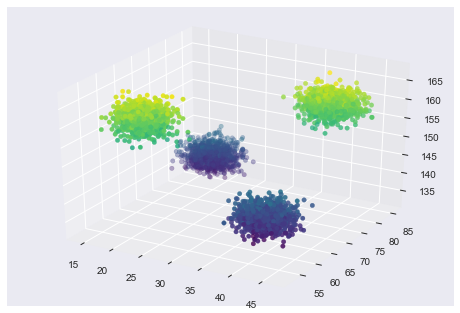

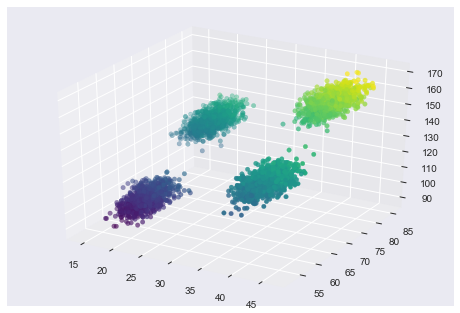

In [13]:
# from model.cgan import CGAN

cgan = CGAN(x_features=X.shape[1],
            y_features=y.shape[1],
            latent_dim=32,
            g_hidden=32,
            d_hidden=32,
            label_smooth=0.9,
            d_dropout=0.1,
            d_clip=0.05)

cgan.fit(dataset, epochs=300, verbose=True)
y_hat = cgan.sample(X)

plot_data(X, y)
plot_data(X, y_hat)

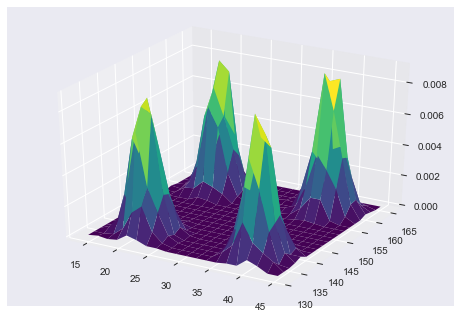

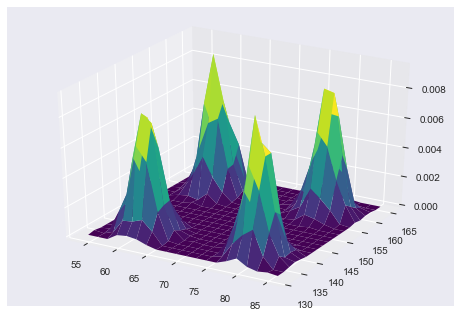

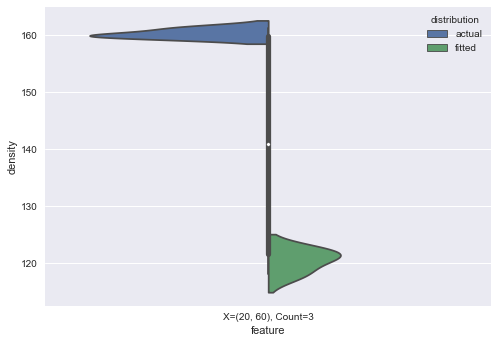

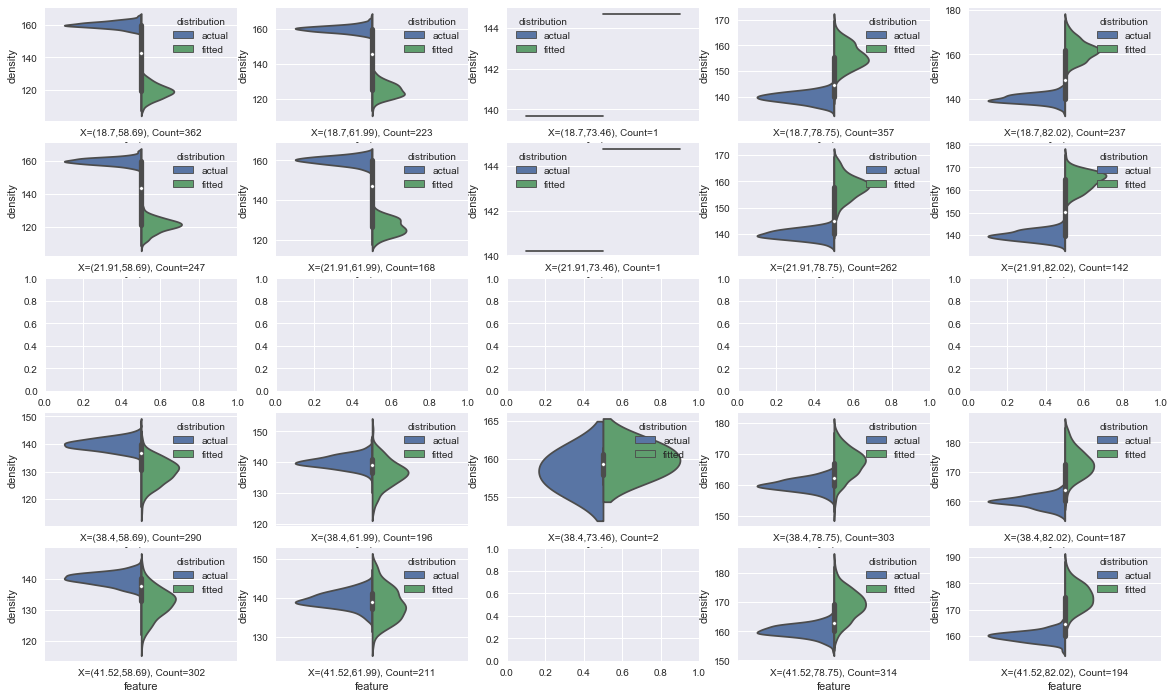

In [6]:
from visualisation.visualisation import Visualisation

viz = Visualisation(cgan, X, y)

# Plot the density function based on X1 and X2
viz.plot_prob(X[:,0], y[:,0], bins=20)
viz.plot_prob(X[:,1], y[:,0], bins=20)

# Plot probability density function given X_fixed across y_range.
# viz.plot_prob_fixed(X_fixed=(20,60), y_range=[0,200], count=200)

# Given X, plot a violin of y based on X within a tolerance, to compare the distribution between fitted and actual.
# X_tol represents the tolerance to which X data is binned to get the corresponding y.
# X_fixed represents the X fed into the model to sample y.
viz.plot_prob_violin(X_fixed=(20,60), X_tol=(0.1,0.1))

# Given X and y, plot a violin of y based on binned X, to compare between fitted and actual.
# For the actual distribution, bin X and plot violin plots for the density of y.
# For the fitted distribution, input the mean of binned X and plot violin plots for the density of sampled y.
viz.plot_binned_violin(bins=5)

In [7]:
from performance.performance import prob_overlap, kl, js

p, q = prob_overlap(y, y_hat, bins=10)
print("KL:", kl(p, q))
print("JS:", js(p, q))

KL: 1.3454403800721628
JS: 0.16586655316895088
